# Policy Scenario Notebook

#### Setup

In [2]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import cfe.regression as rgsn
import numpy as np
import matplotlib.pyplot as plt
from eep153_tools.sheets import read_sheets

In [8]:
r = rgsn.read_pickle('Data/tanz_rgsn')

In [9]:
pbar = pd.read_pickle('Data/pbar.pkl')   # still a Series with the same index & dtypes
fct  = pd.read_pickle('Data/fct.pkl')    # DataFrame intact
rdi  = pd.read_pickle('Data/rdi.pkl')
x = pd.read_pickle('Data/x.pkl')

In [10]:
scenariopbar = []

## Define Your Scenario!
Policy Input Below, apply as new PBar and run the rest of notebook for graph updates

In [11]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import GridBox, Label, Layout


# 1) Build per‐food widgets from pbar.index
food_mult_widgets = {
    j: widgets.FloatText(value=1.0, description='', layout=Layout(width='100px'))
    for j in pbar.index
}

# 2) Global × widget
system_shock = widgets.FloatText(value=1.0, description='Global ×', layout=Layout(width='200px'))

# 3) Per‐nutrient tax widgets from fct.columns
nut_tax_widgets = {
    n: widgets.FloatText(value=0.0, description=n, layout=Layout(width='300px'))
    for n in fct.columns
}

# 4) Reset & output
reset_button = widgets.Button(description='Reset All', button_style='warning')
output = widgets.Output()

# 5) Build 2-col GridBox of food multipliers
labels = [
    Label(value=str(j), layout=Layout(width='200px', justify_content='center'))
    for j in pbar.index
]

inputs = [food_mult_widgets[j] for j in pbar.index]
grid = GridBox(
    children=[val for pair in zip(labels, inputs) for val in pair],
    layout=Layout(
        grid_template_columns='200px 100px',
        grid_row_gap='4px',
        grid_column_gap='8px',
        overflow='auto',
        height='600px',
        width='320px'
    )
)

# 6) Update callback
def update_prices(change=None):
    with output:
        clear_output(wait=True)
        fm = pd.Series({j: w.value for j,w in food_mult_widgets.items()},
                       index=pbar.index)
        sys = system_shock.value
        nt  = pd.Series({n: w.value for n,w in nut_tax_widgets.items()})

        base_price = pbar * fm * sys

        tax_vec = (
            fct
            .mul(nt, axis=1)
            .sum(axis=1)
            .reindex(pbar.index)
            .fillna(0.0)
        )

        newp = base_price + tax_vec
        display(newp)

# 7) Reset callback
def on_reset_widgets(_):
    # reset the global shock
    system_shock.value = 1.0
    # reset every food multiplier back to 1
    for w in food_mult_widgets.values():
        w.value = 1.0
    # reset every nutrient tax/subsidy back to 0
    for w in nut_tax_widgets.values():
        w.value = 0.0

reset_button.on_click(on_reset_widgets)


# 8) Wire up observers
for w in list(food_mult_widgets.values()) + [system_shock] + list(nut_tax_widgets.values()):
    w.observe(update_prices, names='value')

# 9) Tabs layout
tab_food = widgets.VBox([system_shock, grid], layout=Layout(align_items='flex-start'))
tab_nut  = widgets.VBox(list(nut_tax_widgets.values())+[reset_button], layout=Layout(overflow='auto',height='600px'))
tabs     = widgets.Tab([tab_food, tab_nut])
tabs.set_title(0,"Food Multipliers"); tabs.set_title(1,"Nutrient Tax/Subsidy")

# 10) Display
# after your tabs & update_prices definitions…

# 1) helper
def compute_updated_pbar():
    fm = pd.Series({j: w.value for j, w in food_mult_widgets.items()}, index=pbar.index)
    sys = system_shock.value
    nt = pd.Series({n: w.value for n, w in nut_tax_widgets.items()})
    base_price = pbar * fm * sys
    tax_vec = (
        fct
        .mul(nt, axis=1)
        .sum(axis=1)
        .reindex(pbar.index)
        .fillna(0.0)
    )
    return base_price + tax_vec

# 2) apply button
apply_btn = widgets.Button(description="Apply as new pbar", button_style='success')
reset_btn = widgets.Button(description="Reset to base case", button_style='success')
def on_apply(_):
    global scenariopbar
    scenariopbar = compute_updated_pbar()
    print("scenariopbar updated.")
apply_btn.on_click(on_apply)
reset_btn.on_click(on_reset_widgets)
display(apply_btn)
display(reset_btn)
display(tabs, output)
update_prices()


Button(button_style='success', description='Apply as new pbar', style=ButtonStyle())

Button(button_style='success', description='Reset to base case', style=ButtonStyle())

Output()

## Set up

In [12]:
xhat = r.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()
# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median
qhat = (xhat.unstack('j')/pbar).dropna(how='all')
# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]
fct0,c0 = fct.align(qhat.T,axis=0,join='inner')
N = fct0.T@c0
X = np.linspace(xref/5,xref*5,50)
dbar = r.d[rdi.columns].mean()
x0 = xbar.quantile(0.5)  # Household at 0.5 quantile is medianf

In [13]:
def my_prices(j,p0,p=scenariopbar):
    """
    Change price of jth good to p0, holding other prices fixed at p.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

In [14]:
def nutrient_demand(x,p):
    c = r.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

In [15]:
def nutrient_adequacy_ratio(x,p,d,rdi=rdi,days=7):
    hh_rdi = rdi.replace('',0)@d*days

    return nutrient_demand(x,p)/hh_rdi

In [18]:
def nutritional_adequacy_graph(x,pbar,dbar):
    X = np.geomspace(.01*xref,2*xref,100)
    
    pd.DataFrame({x:np.log(nutrient_adequacy_ratio(x,pbar,dbar))[UseNutrients] for x in X}).T.plot()
    plt.legend(UseNutrients)
    plt.xlabel('budget')
    plt.ylabel('log nutrient adequacy ratio')
    plt.axhline(0)
    plt.axvline(xref)
    plt.title('Log Nutrient Adequacy Ratio vs. Budget')

In [21]:
from helper_functions import analyze_good

## Good Specific Analysis

In [28]:
import pandas as pd
import cfe.regression as rgsn
import numpy as np
import matplotlib.pyplot as plt
from eep153_tools.sheets import read_sheets


def analyze_good(
    good: str,
    r,
    x0,
    pbar: pd.Series,
    dbar: pd.Series,
    xref: float,
    UseNutrients: list[str],
    nutrient_demand,
    nutrient_adequacy_ratio,
    price_multipliers: np.ndarray = None,
    budget_multipliers: np.ndarray = None,
    figsize: tuple = (12, 16)
):
    """
    - Varies pbar[good] over `price_multipliers` and replots:
        1) Marshallian vs Hicksian demand
        2) Log nutrient adequacy vs Price
        3) Log nutrient adequacy vs Budget
    - Assumes pbar already holds your baseline (and any other shocks).
    """
    # defaults
    if price_multipliers is None:
        price_multipliers = np.geomspace(0.01, 10, 50)
    if budget_multipliers is None:
        budget_multipliers = np.geomspace(0.01, 2, 50)

    # 1) Demand curves
    prices = price_multipliers * pbar[good]
    U0 = r.indirect_utility(x0, pbar)
    q_marshall, q_hicksian = [], []
    for p in prices:
        pvec = pbar.copy(); pvec[good] = p
        q_marshall.append(r.demands(x0, pvec)[good])
        q_hicksian.append(r.demands(U0, pvec, type="Hicksian")[good])

    # 2) Nutrient adequacy vs. Price
    nar_price_dict = {}
    for p in prices:
        pvec = pbar.copy(); pvec[good] = p
        nar = nutrient_adequacy_ratio(xref/4, pvec, dbar)
        nar_price_dict[p] = np.log(nar[UseNutrients])
    nar_vs_price = pd.DataFrame(nar_price_dict).T

    # 3) Nutrient adequacy vs. Budget
    budgets = budget_multipliers * xref
    nar_budget_dict = {}
    for b in budgets:
        nar_b = nutrient_demand(b, pbar)
        nar_budget_dict[b] = np.log(nar_b[UseNutrients])
    nar_vs_budget = pd.DataFrame(nar_budget_dict).T

    # Plot setup
    fig, axes = plt.subplots(3, 1, figsize=figsize, constrained_layout=True)

    # -- Plot 1: Demand Curves --
    ax = axes[0]
    ax.plot(q_marshall, prices, lw=2, label='Marshallian')
    ax.plot(q_hicksian, prices, lw=2, label='Hicksian')
    ax.set_title(f"{good}: Marshallian vs. Hicksian Demand", fontweight='bold')
    ax.set_xlabel(f"Quantity of {good}", fontweight='bold')
    ax.set_ylabel("Price", fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(0.5, -0.2,
            "Marshallian: demand at fixed income; Hicksian: compensated demand.",
            ha='center', va='top', transform=ax.transAxes, style='italic')

    # -- Plot 2: Nutrient Adequacy vs. Price --
    ax = axes[1]
    for nut in nar_vs_price.columns:
        ax.plot(nar_vs_price[nut], nar_vs_price.index, lw=2, label=nut)
    ax.set_title(f"{good}: Log Nutrient Adequacy vs. Price", fontweight='bold')
    ax.set_xlabel("Log Nutrient Adequacy Ratio", fontweight='bold')
    ax.set_ylabel("Price", fontweight='bold')
    ax.axhline(pbar[good], color='gray', ls='--', lw=1)
    ax.axvline(0, color='gray', ls='--', lw=1)
    ax.legend(title="Nutrient")
    ax.grid(alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(0.5, -0.2,
            "Each curve shows how adequacy changes as the staple's price varies.",
            ha='center', va='top', transform=ax.transAxes, style='italic')

    # -- Plot 3: Nutrient Adequacy vs. Budget --
    ax = axes[2]
    for nut in nar_vs_budget.columns:
        ax.plot(nar_vs_budget[nut], nar_vs_budget.index, lw=2, label=nut)
    ax.set_title(f"{good}: Log Nutrient Adequacy vs. Budget", fontweight='bold')
    ax.set_xlabel("Log Nutrient Adequacy Ratio", fontweight='bold')
    ax.set_ylabel("Budget", fontweight='bold')
    ax.axhline(0, color='gray', ls='--', lw=1)
    ax.legend(title="Nutrient")
    ax.grid(alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(0.5, -0.2,
            "Each curve shows how adequacy changes as total budget varies.",
            ha='center', va='top', transform=ax.transAxes, style='italic')

    plt.show()


def nutritional_adequacy_graph(x,pbar,dbar):
    X = np.geomspace(.01*xref,2*xref,100)
    
    pd.DataFrame({x:np.log(nutrient_adequacy_ratio(x,pbar,dbar))[UseNutrients] for x in X}).T.plot()
    plt.legend(UseNutrients)
    plt.xlabel('budget')
    plt.ylabel('log nutrient adequacy ratio')
    plt.axhline(0)
    plt.axvline(xref)
    plt.title('Log Nutrient Adequacy Ratio vs. Budget')

def nutrient_adequacy_ratio(x,p,d,rdi=rdi,days=7):
    hh_rdi = rdi.replace('',0)@d*days

    return nutrient_demand(x,p)/hh_rdi

def nutrient_demand(x,p):
    c = r.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N


def my_prices(j,p0,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed at p.
    """
    p = p.copy()
    p.loc[j] = p0
    return p



**Possible goods include** 'Beef', 'Bread', 'Citrus Fruits', 'Coconuts', 'Cooking Oil', 'Eggs',
       'Fish (fresh)', 'Irish Potatoes', 'Leafy Greens', 'Maize (flour)',
       'Milk (fresh)', 'Other Fruits', 'Plantains', 'Pulses', 'Rice (husked)',
       'Ripe Bananas', 'Salt', 'Soft drinks', 'Sugar', 'Tea (dry)',
       'Vegetables (fresh)', and 'Wheat Flour'. This is the output of r.beta.index.

**Possible nutrients include** ['Energy', 'Protein', 'Vitamin A', 'Vitamin D', 'Vitamin E', 'Vitamin C',
       'Vitamin B-6', 'Vitamin B-12', 'Calcium', 'Magnesium', 'Iron', 'Zinc']

In [29]:
Analysis_Good = 'Bread'
Analysis_Nutrients = ['Energy', 'Protein', 'Vitamin A', 'Vitamin D', 'Vitamin E', 'Vitamin C',
       'Vitamin B-6', 'Vitamin B-12', 'Calcium', 'Magnesium', 'Iron', 'Zinc']

/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -1.76E+13.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))
/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -1.46E-11.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))


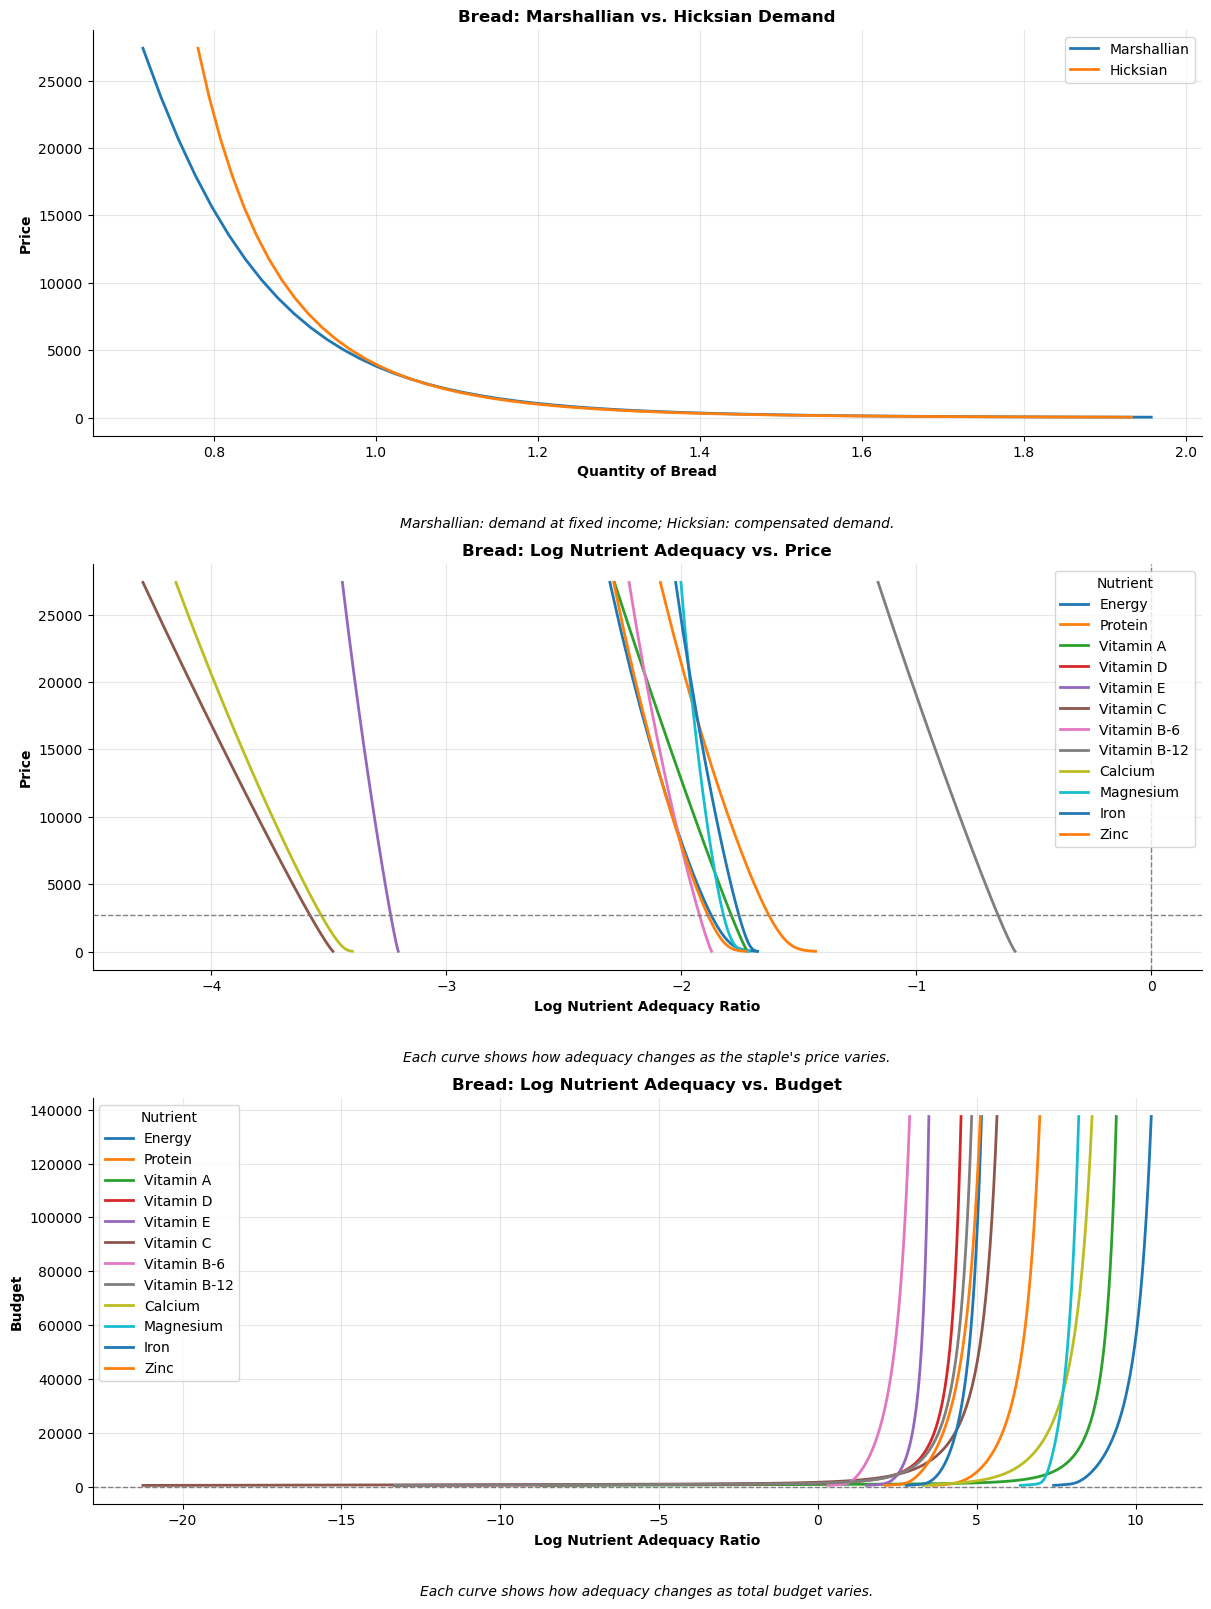

In [37]:
#run this cell to analyze the good!
analyze_good(
    good=Analysis_Good,
    r=r,
    x0=x0,
    pbar= scenariopbar,
    dbar=dbar,
    xref=xref,
    UseNutrients=Analysis_Nutrients,
    nutrient_demand=nutrient_demand,
    nutrient_adequacy_ratio=nutrient_adequacy_ratio
)


## Household Nutritional Adequacy

In [115]:
def nutritional_adequacy_graph(x,pbar,dbar, Analysis_Nutrients):
    X = np.geomspace(.01*xref,2*xref,100)
    
    pd.DataFrame({x:np.log(nutrient_adequacy_ratio(x,pbar,dbar))[Analysis_Nutrients] for x in X}).T.plot()
    plt.legend(Analysis_Nutrients)
    plt.xlabel('budget')
    plt.ylabel('log nutrient adequacy ratio')
    plt.axhline(0)
    plt.axvline(xref)
    plt.title('Log Nutrient Adequacy Ratio vs. Budget')

/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -4.97E+86.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))
/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -7.66E+53.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))
/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -2.91E-11.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps toleranc

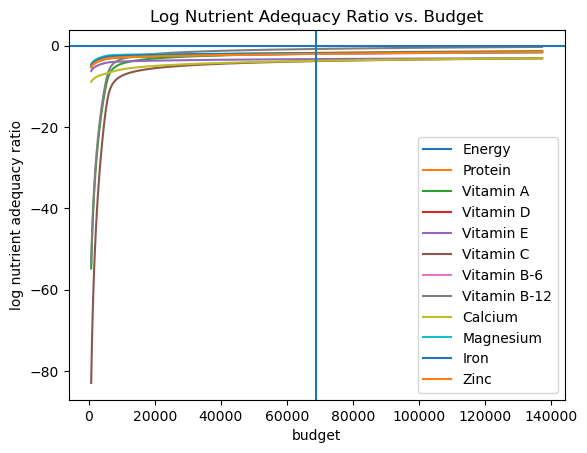

In [119]:
nutritional_adequacy_graph(x,scenariopbar,dbar,Analysis_Nutrients)

In [ ]:
xhat_df = xhat.unstack('j')
qhat_list = []
idx_list = []
for idx, exp_row in xhat_df.iterrows():
    t, m = idx[1], idx[2]
    try:
        price_vector = p_df.loc[(t, m)]
        common_goods = exp_row.index.intersection(price_vector.index)
        q_row = exp_row[common_goods] / price_vector[common_goods]
        qhat_list.append(q_row)
        idx_list.append(idx)
    except KeyError:
        continue
qhat = pd.DataFrame(qhat_list, index=idx_list)
qhat = qhat.loc[:, qhat.count() > 0]
if isinstance(qhat.columns, pd.MultiIndex):
    qhat.columns = qhat.columns.get_level_values(0).str.strip().str.lower()
else:
    qhat.columns = qhat.columns.astype(str).str.strip().str.lower()

# Nutrient Intake Estimation via Baseline FCT
common_goods_baseline = fct.index.intersection(qhat.columns)
baseline_nutrients = qhat[common_goods_baseline].dot(fct.loc[common_goods_baseline])
baseline_nutrients.columns = baseline_nutrients.columns.astype(str).str.strip().str.lower()
if not isinstance(baseline_nutrients.index, pd.MultiIndex):
    baseline_nutrients.index = pd.MultiIndex.from_tuples(baseline_nutrients.index, names=['i','t','m'])


# Household Nutrient Requirements via RDI
d_adj = d.copy()
d_adj["Child_1_3"]   = d_adj["Females 00-03"] + d_adj["Males 00-03"]
d_adj["Female_4_8"]    = d_adj["Females 04-08"]
d_adj["Male_4_8"]      = d_adj["Males 04-08"]
d_adj["Female_9_13"]   = d_adj["Females 09-13"]
d_adj["Male_9_13"]     = d_adj["Males 09-13"]
d_adj["Female_14_18"]  = d_adj["Females 14-18"]
d_adj["Male_14_18"]    = d_adj["Males 14-18"]
d_adj["Female_19_30"]  = d_adj["Females 19-30"]
d_adj["Male_19_30"]    = d_adj["Males 19-30"]
d_adj["Female_31_50"]  = d_adj["Females 31-50"]
d_adj["Male_31_50"]    = d_adj["Males 31-50"]
d_adj["Female_51U"]    = d_adj["Females 51-99"]
d_adj["Male_51U"]      = d_adj["Males 51-99"]

demo_cols = ["Child_1_3", "Female_4_8", "Male_4_8", "Female_9_13", "Male_9_13",
             "Female_14_18", "Male_14_18", "Female_19_30", "Male_19_30",
             "Female_31_50", "Male_31_50", "Female_51U", "Male_51U"]
d_demo = d_adj[demo_cols]
common_demo = [col for col in rdi.columns if col in d_demo.columns]
d_demo = d_demo[common_demo]
hh_rdi = d_demo.dot(rdi[common_demo].T)
hh_rwi = hh_rdi * 28
hh_rwi.columns = hh_rwi.columns.astype(str).str.strip().str.lower()
if not isinstance(hh_rwi.index, pd.MultiIndex):
    hh_rwi.index = pd.MultiIndex.from_tuples(hh_rwi.index, names=['i','t','m'])


# 7. Simulate a New Scenario and Recalculate Nutrient Intakes
scenario_params = {
    "budget_multiplier": 0.8,
    "price_multipliers": {"teff": 1, "oils":1, "beef":10, "onion":1}
}
nutrientofinterest = "energy"

# Compute Baseline Intake Ratio Distribution
baseline_protein_ratio = baseline_nutrients[nutrientofinterest] / hh_rwi[nutrientofinterest]

budget_mult = scenario_params["budget_multiplier"]
price_mult_lower = {k.lower(): v for k, v in scenario_params.get("price_multipliers", {}).items()}
simulated_q = qhat.copy()
for good in simulated_q.columns:
    good_lower = good.lower()
    if good_lower in price_mult_lower:
        simulated_q[good] = simulated_q[good] * (budget_mult / price_mult_lower[good_lower])
    else:
        simulated_q[good] = simulated_q[good] * budget_mult

# Recalculate nutrient intakes for the simulated scenario.
common_goods_sim = fct.index.intersection(simulated_q.columns)
if common_goods_sim.empty:
    raise KeyError("No common goods found between simulated consumption and FCT.")
simulated_nutrients = simulated_q[common_goods_sim].dot(fct.loc[common_goods_sim])
simulated_nutrients.columns = simulated_nutrients.columns.astype(str).str.strip().str.lower()
if not isinstance(simulated_nutrients.index, pd.MultiIndex):
    simulated_nutrients.index = pd.MultiIndex.from_tuples(simulated_nutrients.index, names=['i','t','m'])
# Compute the simulated protein intake ratio.
simulated_protein_ratio = simulated_nutrients[nutrientofinterest] / hh_rwi[nutrientofinterest]

# Plot the Baseline and Simulated Intake Distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(baseline_protein_ratio, bins=100, color="blue", alpha=0.7)
plt.xlabel("Intake Ratio (Actual / Recommended)")
plt.ylabel("Frequency")
plt.title("Baseline Intake Ratio Distribution")

plt.subplot(1, 2, 2)
plt.hist(simulated_protein_ratio, bins=100, color="green", alpha=0.7)
plt.xlabel("Intake Ratio (Actual / Recommended)")
plt.ylabel("Frequency")
plt.title("Simulated Intake Ratio Distribution")

plt.tight_layout()
plt.show()